In [1]:
import proposal as pp
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.labelsize'] = 14

In [2]:
pp.InterpolationSettings.tables_path = "/tmp" # save interpolation tables to folder
N_SAMPLES = int(1e4)

# Interaction Object
The interaction is used to sample stochastic losses as well as energies when the stochastic loss will occur.

*When executed for the first time, the following cell will take some time since interpolation tables are built*

In [3]:
args = {
    "particle_def": pp.particle.MuMinusDef(),
    "target": pp.medium.Ice(),
    "interpolate": True,
    "cuts": pp.EnergyCutSettings(500, 1, False)
}

cross = pp.crosssection.make_std_crosssection(**args)
inter = pp.make_interaction(cross, False)

## Sampling Energie where next stochastic interaction take place
The energy where the next stochastic loss occurs is sampled by solving the energy integral

$$ \int_{E_i}^{E_f} \frac{\sigma(E)}{-f(E)} \mathrm{d}E = - \log(\xi) $$

for $E_f$ where $E_i$ is the initial particle energy, $\sigma(E)$ the total stochastic crosssetion, $f(E)$ the average continuous energy loss and $\xi \in [0, 1)$ a random number. This sampling is provided by the method `energy_interaction`:

Text(0, 0.5, 'energy of next stochastic loss $\\,/\\, \\mathrm{MeV} $')

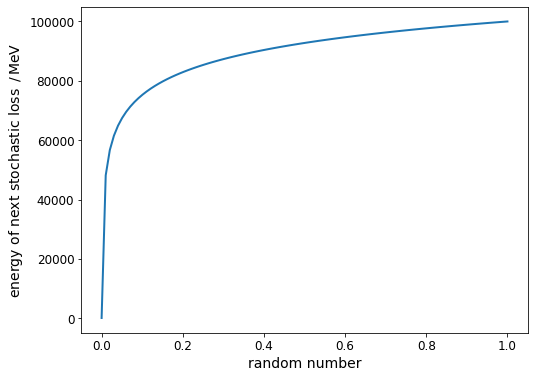

In [4]:
energy = 1e5 # initial energy in MeV
rnd = np.linspace(1e-5,1,100)
plt.plot(rnd, inter.energy_interaction(energy, rnd))
plt.xlabel("random number")
plt.ylabel(r'energy of next stochastic loss $\,/\, \mathrm{MeV} $')

## Mean free path length
The interaction module also provides the mean free path length, i.e. $\lambda = \sigma_{\mathrm{tot, stoch}}(E)^{-1}$:

Text(0, 0.5, '$\\lambda \\,\\left/\\, \\left( \\rm{g} \\,/\\, \\rm{cm}^2 \\right) \\right. $')

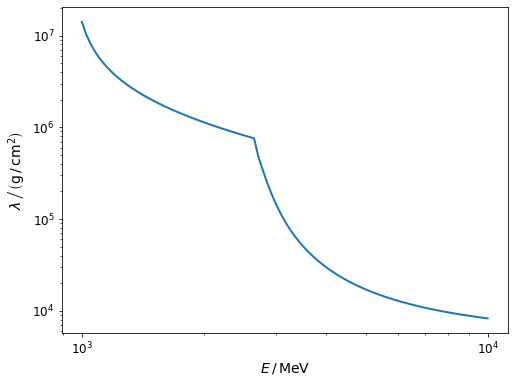

In [5]:
energies = np.geomspace(1e3, 1e4, 100)
plt.plot(energies, inter.mean_free_path(energies))
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r'$E \,/\, \mathrm{MeV} $')
plt.ylabel(r'$\lambda \,\left/\, \left( \rm{g} \,/\, \rm{cm}^2 \right) \right. $')

## Combined Rates
We can also look at the interaction rates per interaction and per component: 

In [6]:
rates_comp_inter = {}
for e in energies:
    for rate in inter.rates(e):
        if (rate.crosssection.type, rate.comp_hash) in rates_comp_inter:
            rates_comp_inter[(rate.crosssection.type, rate.comp_hash)].append(rate.rate)
        else:
            rates_comp_inter[(rate.crosssection.type, rate.comp_hash)] = [rate.rate]            

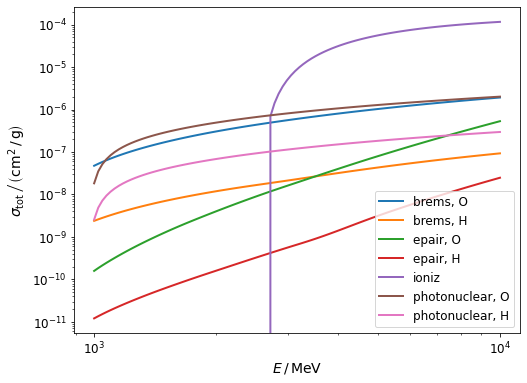

In [7]:
for (cross_type, comp), values in rates_comp_inter.items():
    if comp == args["target"].hash:
        label = f"{cross_type.name}"
    else:
        label = f"{cross_type.name}, {pp.component.get_component_for_hash(comp).name}"
    plt.plot(energies, values, label=label)
plt.xlabel(r'$E \,/\, \mathrm{MeV} $')
plt.ylabel(r'$\sigma_\mathrm{tot} \,\left/\, \left( \rm{cm^2} \,/\, \rm{g} \right) \right. $')
plt.xscale("log")
plt.yscale("log")
plt.legend()

## Sample Loss
The function `sample_loss` samples a stochastic interaction, based on stochastic interaction rates and a random number. Here, we visualize all possible stochastic interactions and the corresponding relative energy loss $v$.

In [8]:
import random
energy = 1e5 # initial energy in MeV
rates = inter.rates(energy)

rates_dict = {}
for r in rates:
    rates_dict[(r.crosssection.type.name, r.comp_hash)] = []

N_RND = int(1e5)
rnds = np.linspace(0, 1, N_RND)
for rnd in rnds:
    loss = inter.sample_loss(energy, rates, rnd)
    rates_dict[(loss.type.name, loss.comp_hash)].append(loss.v_loss)

order = np.argsort([len(x) for x in rates_dict.values()])
reordered_keys = [list(rates_dict.keys())[i] for i in order]
reordered_dict = {k: rates_dict[k] for k in reordered_keys}

The transparency in the following plot indicates the medium component

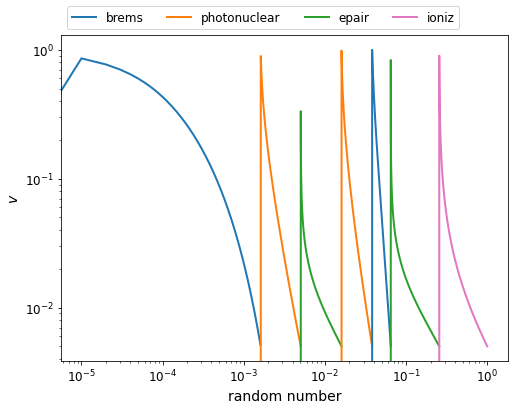

In [9]:
colors = {}
alphas = {}
pos = 0
for i, ((cross, comp), values) in enumerate(reordered_dict.items()):
    label = None
    if cross not in colors:
        colors[f"{cross}"] = f"C{i}"
        label = f"{cross}"
    color = colors[f"{cross}"]
    try:
        comp_name = pp.component.component_map()[comp].name
        if f"{comp_name}" not in alphas:
            alphas[f"{comp_name}"] = 1 / (len(alphas)+1)
        alpha = alphas[f"{comp_name}"]
    except:
        alpha = 1
    rnd = np.linspace(pos, pos+len(values), len(values)+1) /N_RND
    plt.plot(
        rnd, 
        np.append(0,values), 
        label=label, 
        color=color, 
        alpha=alpha
    )
    pos += len(values)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r'random number')
plt.ylabel(r'$v$')
plt.legend(loc='lower left', bbox_to_anchor=(0, 1.), ncol=4)